# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.weightstats import ztest

size_sim = 10000
alpha = 0.05    #Significance level

In [3]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


# Helper Methods

In [11]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [10]:
def draw_bs_reps(data, func, size=1):
    bs_reps = np.empty(size)
    for i in range(size):
        bs_sample = np.random.choice(data, size=len(data))
        bs_rep = func(bs_sample)
        bs_reps[i] = bs_rep
    return bs_reps

# 1. Is the distribution of body temperatures normal?

(array([0.06837607, 0.06837607, 0.06837607, 0.13675214, 0.30769231,
        0.20512821, 0.34188034, 0.54700855, 0.61538462, 0.41025641,
        0.61538462, 0.41025641, 0.37606838, 0.13675214, 0.03418803,
        0.        , 0.06837607, 0.        , 0.        , 0.03418803]),
 array([ 96.3  ,  96.525,  96.75 ,  96.975,  97.2  ,  97.425,  97.65 ,
         97.875,  98.1  ,  98.325,  98.55 ,  98.775,  99.   ,  99.225,
         99.45 ,  99.675,  99.9  , 100.125, 100.35 , 100.575, 100.8  ]),
 <a list of 20 Patch objects>)

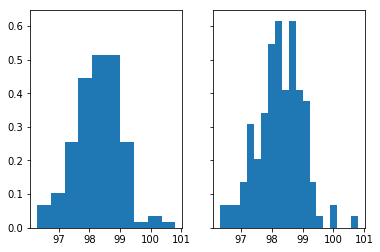

In [60]:
# Visualize temperature data
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(df.temperature, bins=10, density=True)
axs[1].hist(df.temperature, bins=20, density=True)

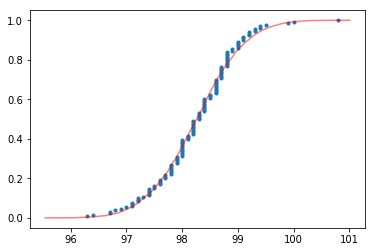

In [33]:
# Plot temperature ECDF
x_temp, y_temp = ecdf(df.temperature)
plt.plot(x_temp, y_temp, marker='.', linestyle='none')


# Plot normal temperature ECDF
mu_temp = np.mean(df.temperature)
sigma_temp = np.std(df.temperature)
norm_temp = np.random.normal(mu_temp, sigma_temp, size_sim)
x_norm_temp, y_norm_temp = ecdf(norm_temp)
plt.plot(x_norm_temp, y_norm_temp, color='red', alpha=0.5)

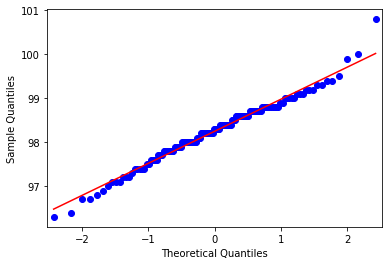

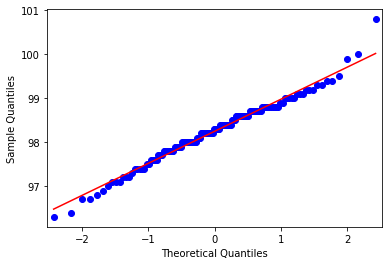

In [8]:
# Quantile-Quantile PlotQQ plot
qqplot(df.temperature, line='s')

In [18]:
# Shapiro-Wilk Test
_, p = stats.shapiro(df.temperature)
if p > 0.05:
    print('The distribution of Body temperature looks normal')
else:
    print('The distribution of body temperature does not look normal')

The distribution of Body temperature looks normal


From the plots and test, we can conclude that the distribution of body temperature **is normal**.

# 2. Is the sample size large? Are the observations independent?

In [10]:
df.count() > 30

temperature    True
gender         True
heart_rate     True
dtype: bool

The sample size is larger than thirty which can ba considered as **large enough**.

A person's temperature and heart rate are hard to affect another's unless they're physical very close to each other during observation. So the observations can be considered as **independent**.

# 3. Is the true population mean really 98.6 degrees F?

## Bootstrap Hypothesis Test

**H0: The true population mean is 98.6F.**

In [12]:
true_temp_mean = 98.6
bs_mean = draw_bs_reps(df.temperature, func=np.mean, size=10000)
p = np.sum(bs_mean >= true_temp_mean) / len(bs_mean)
if p > alpha:
    print(f'The true population mean is {true_temp_mean}F (Fail to reject H0)')
else:
    print(f'The true population mean is not {true_temp_mean}F (Reject H0)')

The true population mean is not 98.6F (Reject H0)


The true population mean is **not** 98.6 degrees F.

## Frequentist Statistical Test

As we are testing if the population mean of the body temperature is equal to a constant (in this case 98.6) instead of if the body temperature of men and women are identical, we should use **one-sample test**.

As the standard deviation of population is unknown, **t statistic test** is often more accurate in this case.

### T Test By Hand

In [34]:
n = len(df.temperature)
t = (mu_temp - true_temp_mean) / sigma_temp * np.sqrt(n)
p = (1 - stats.t.cdf(np.abs(t), df=n-1)) * 2
print(f't: {t}, p: {p}')

t: -5.475925202078116, p: 2.1887464618508545e-07


### T Test By SciPy

In [15]:
t, p = stats.ttest_1samp(df.temperature, true_temp_mean)
print(f't: {t}, p: {p}')
if p > alpha:
    print(f'The true population mean is {true_temp_mean}F (Fail to reject H0)')
else:
    print(f'The true population mean is not {true_temp_mean}F (Reject H0)')    

t: -5.4548232923645195, p: 2.4106320415561276e-07
The true population mean is not 98.6F (Reject H0)


### Z Test

In [46]:
z, p = ztest(df.temperature)
print(f'z: {z}, p: {p}')
if p > alpha:
    print(f'The true population mean is {true_temp_mean}F (Fail to reject H0)')
else:
    print(f'The true population mean is not {true_temp_mean}F (Reject H0)')

z: 1527.8768644603886, p: 0.0
The true population mean is not 98.6F (Reject H0)


# 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [7]:
df_temp_10 = df.temperature.sample(n=10, random_state=1)

### T Test

In [16]:
t, p = stats.ttest_1samp(df_temp_10, true_temp_mean)
print(f't: {t}, p: {p}')
if p > alpha:
    print(f'The true population mean is {true_temp_mean}F (Fail to reject H0)')
else:
    print(f'The true population mean is not {true_temp_mean}F (Reject H0)')    

t: -1.9658186252250536, p: 0.08088423631974037
The true population mean is 98.6F (Fail to reject H0)


### Z Test

In [14]:
z, p = ztest(df_temp_10)
print(f'z: {z}, p: {p}')
if p > alpha:
    print(f'The true population mean is {true_temp_mean}F (Fail to reject H0)')
else:
    print(f'The true population mean is not {true_temp_mean}F (Reject H0)')

z: 350.4518476423954, p: 0.0
The true population mean is not 98.6F (Reject H0)


(array([0.35714286, 0.35714286, 0.71428571, 0.        , 0.35714286,
        0.35714286, 0.35714286, 0.71428571, 0.        , 0.35714286]),
 array([96.7 , 96.98, 97.26, 97.54, 97.82, 98.1 , 98.38, 98.66, 98.94,
        99.22, 99.5 ]),
 <a list of 10 Patch objects>)

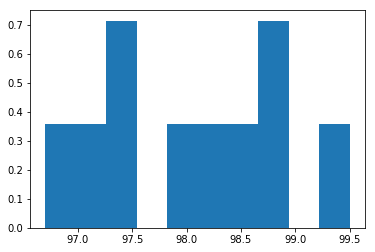

In [59]:
# Plot distribution of the sample
plt.hist(df_temp_10, density=True)

T test for small sample shows a different result. It fails to reject H0.

The reason is that the sample size is too small and not normally distributed.

# 5. At what temperature should we consider someone's temperature to be "abnormal"?

### Assume confidence level is 95%

In [98]:
conf_lev = 0.95
conf_decimals = 3
temp_decimals = 1

## Bootstrap Test

As we're estimating the abnormal temperature, I choose to use __confidence interval__ as test statistics.

In [76]:
conf_per_low = round(0 + (1-conf_lev)/2, decimals)
conf_per_high = round(1 - (1-conf_lev)/2, decimals)

In [88]:
print(f'Percentiles are {conf_per_low, conf_per_high}')

Percentiles are (0.025, 0.975)


In [114]:
df_temp_conf_int = np.percentile(df.temperature, [conf_per_low, conf_per_high])
# Round values
df_temp_conf_int = [round(temp, temp_decimals) for temp in df_temp_conf_int]
print(f'Confidence interval for sample body temperature is {df_temp_conf_int}')

Confidence interval for sample body temperature is [96.3, 96.5]


In [115]:
# Helper method to draw bootstrap replicates of confidence interval
def draw_bs_rep_per(data, conf_pers, size=1):
    bs_con_int_low = np.empty(size)
    bs_con_int_high = np.empty(size)
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_con_int = np.percentile(bs_sample, conf_pers)
        bs_con_int_low[i], bs_con_int_high[i] = [round(temp, temp_decimals) for temp in bs_con_int]
    return bs_con_int_low, bs_con_int_high

In [116]:
bs_con_int_low, bs_con_int_high = draw_bs_rep_per(df.temperature, [conf_per_low, conf_per_high], size=10000)

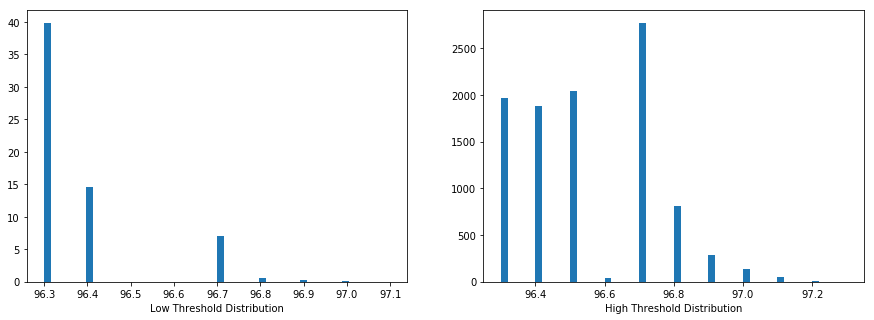

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(bs_con_int_low, bins=50, density=True)
axs[0].set_xlabel('Low Threshold Distribution')
axs[1].hist(bs_con_int_high, bins=50, density=False)
axs[1].set_xlabel('High Threshold Distribution')
plt.show()

### As neither of bootstrap relicates looks like normally distributted. Bootstrap may not be approperate for this test. But let's try to use them to test the hypothesis.

In [125]:
print(f'Confidence interval for sample body temperature is {df_temp_conf_int}')

Confidence interval for sample body temperature is [96.3, 96.5]


### H0: Body temperture which is lower than 96.3F is abnormal.

In [129]:
p_low = np.sum(bs_con_int_low <= df_temp_conf_int[0]) / len(bs_con_int_low)
if p_low > alpha:
    print(f'Body temperature which is lower than 96.3F is abnormal (Fail to reject H0)')
else:
    print(f'Body temperature which is lower then 96.3F is normal (Rject H0)')

Body temperature which is lower than 96.3F is abnormal (Fail to reject H0)


### H0: Body temperture which is larger than 96.5F is abnormal.

In [130]:
p_high = np.sum(bs_con_int_high >= df_temp_conf_int[1]) / len(bs_con_int_high)
if p_high > alpha:
    print(f'Body temperature which is larger than 96.5F is abnormal (Fail to reject H0)')
else:
    print(f'Body temperature which is larger then 96.5F is normal (Rject H0)')

Body temperature which is larger than 96.5F is abnormal (Fail to reject H0)


## Frequentist Test

### Z Test

In [120]:
z = stats.norm.ppf(q=conf_per_high)
print(f'z score is {z}')

z score is 1.959963984540054


In [121]:
margin_of_error = z * (sigma_temp / np.sqrt(len(df.temperature)))
print(f'Margin of error is {margin_of_error}')

Margin of error is 0.12554865777413815


In [124]:
conf_int_low = (df_temp_conf_int[0] - margin_of_error, df_temp_conf_int[0] + margin_of_error)
conf_int_high = (df_temp_conf_int[1] - margin_of_error, df_temp_conf_int[1] + margin_of_error)
print(f'Confidence interval for lower threshold is {conf_int_low}')
print(f'Confidence interval for higher threshold is {conf_int_high}')

Confidence interval for lower threshold is (96.17445134222586, 96.42554865777413)
Confidence interval for higher threshold is (96.37445134222587, 96.62554865777413)


# 6. Is there a significant difference between males and females in normal temperature?

## Bootstrap Test

### H0: Means of male and female temperature are the same.

In [131]:
# Helper function to concat and permute two data sets
def perm_sample(data1, data2):
    data = np.concatenate((data1, data2))
    data = np.random.permutation(data)
    perm_data_1 = data[:len(data1)]
    perm_data_2 = data[len(data1):]
    return perm_data_1, perm_data_2

In [133]:
# Helper function to draw bootstrap replicates from permutated data
def draw_perm_reps(data1, data2, func, size=1):
    perm_reps = np.empty(size)
    for i in range(size):
        perm_data_1, perm_data_2 = perm_sample(data1, data2)
        perm_reps[i] = func(perm_data_1, perm_data_2)
    return perm_reps

In [140]:
# Helper function to calculate the difference of means between two data sets
def mean_diff(data1, data2):
    return np.mean(data1) - np.mean(data2)

In [152]:
male_temp = df[df.gender == 'M'].temperature
female_temp = df[df.gender == 'F'].temperature
sample_mean_diff = mean_diff(male_temp, female_temp)
perm_reps = draw_perm_reps(male_temp, female_temp, mean_diff, size=10000)
print(f'Difference of sample means is {sample_mean_diff}')

Difference of sample means is -0.289230769230727


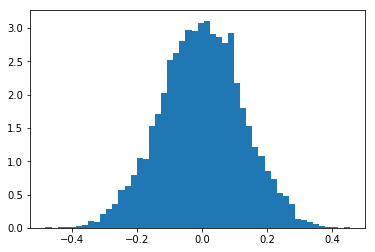

In [151]:
plt.hist(perm_reps, bins=50, density=True)
plt.show()

In [148]:
p_perm = np.sum(perm_reps <= sample_mean_diff) / len(perm_reps)
if p_perm > alpha:
    print(f'Body temperature which is larger than 96.5F is abnormal (Fail to reject H0)')
else:
    print(f'Body temperature which is larger then 96.5F is normal (Rject H0)')

Body temperature which is larger then 96.5F is normal (Rject H0)


In [149]:
p_perm

0.0117

T test should be used for two reasons:
1. Population standard deviation is unknow.
2. Comparison between two sample means.